# Pingvin-datasættet
### Hentet fra:
https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species

### Features

> **Datasættets features er:**
> - `culmen_length_mm` (længden af næbbet målt i mm)
> - `culmen_depth_mm` (tykkelsen af næbbet målt i mm)
> - `flipper_length_mm` (vingernes længde målt i mm)
> - `body_mass_g` (kropsvægten målt i g)
> - `sex` (kønnet, enten 'FEMALE' eller 'MALE')
>
> &nbsp;

### Problemstilling

> *Kan pingvinerne inddeles i klynger på en meningsfuld måde ud fra det givne datasæt.*

### Databehandling

> **Databehandlingen følger nedenstående skridt:**
> 1. Indlæs filen til en Pandas DataFrame
> 2. Rens data
> 3. Skalér data som forberedelse til K-means clustering
> 4. Anvend "albuemetoden" som forberedelse til K-means clustering
> 5. Anvend K-means clustering
> 6. Beskriv de forskellige klynger
>
> &nbsp;

<img src="penguin.jpg" alt="Pingvin" style="height: 300px; width:300px;"/>

1. Indlæs data til Pandas

_Vi indlæser samtidig en del af de biblioteker, som vi forventligt får brug for._

In [87]:
data_file = "penguins.csv"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv(data_file)

2. Første kig på data og rensning.

_Vi kigger på, hvor mange datarækker, der er, og hvad typerne er. Vi ser også, om der er manglende værdier, og om der er fejl-værdier af nogen art, f.eks. outliers._

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


_Der er 344 rækker i datasættet, men der mangler nogle værdier nogle steder, da der f.eks. kun er 335 værdier i søjlen 'sex'._

_Vi undersøger først null-værdier._

In [89]:
df[df.isna().any(axis=1)]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,NaN,NaN,NaN,NaN,NaN
8,34.1,18.1,193.0,3475.0,NaN
10,37.8,17.1,186.0,3300.0,NaN
11,37.8,17.3,180.0,3700.0,NaN
47,37.5,18.9,179.0,2975.0,NaN
246,44.5,14.3,216.0,4100.0,NaN
286,46.2,14.4,214.0,4650.0,NaN
324,47.3,13.8,216.0,4725.0,NaN
339,NaN,NaN,NaN,NaN,NaN


_Der er to null-rækker, og så mangler der køn på 7 pingviner. Vi vælger at fjerne alle 9 rækker._

In [90]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   335 non-null    float64
 1   culmen_depth_mm    335 non-null    float64
 2   flipper_length_mm  335 non-null    float64
 3   body_mass_g        335 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.2+ KB


_Vi ser, at datatypen for kolonnen 'sex' er 'object'. Vi undersøger værdierne nærmere._

In [92]:
df['sex'].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

_Vi har lavet en optælling af værdier i 'sex'-kolonnen, og opdager her en fejlværdi, da der er sat et '.' ind for kønnet på en af pingvinerne._

_Vi fjerner rækken med '.' som køn._

In [93]:
df.drop(df.query('sex == "."').index, inplace=True)
df['sex'].value_counts()

sex
MALE      169
FEMALE    165
Name: count, dtype: int64

_Vi konstaterer, at kønsfordelingen i datasættet er nogenlunde ligelig._

In [94]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,334.0,43.986826,5.461540,32.1,39.5,44.45,48.575,59.6
culmen_depth_mm,334.0,17.173952,1.973277,13.1,15.6,17.30,18.700,21.5
flipper_length_mm,334.0,214.347305,263.648447,-132.0,190.0,197.00,213.000,5000.0
body_mass_g,334.0,4207.185629,804.009294,2700.0,3550.0,4050.00,4768.750,6300.0


_Der er noget galt med værdierne i kolonnen 'flipper_length_mm', da der er en negativ værdi og en værdi på 5000 (5 meter lang vinge)._

_Derfor undersøger vi denne kolonne nærmere._

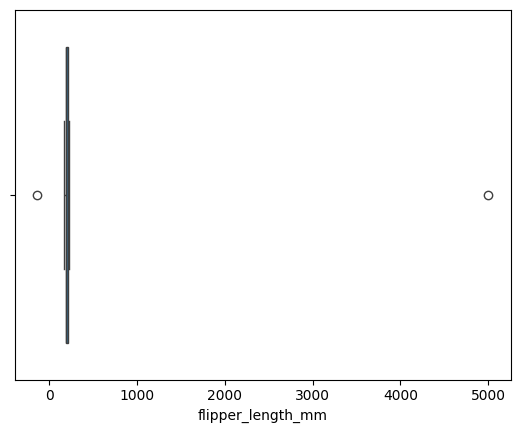

In [95]:
sns.boxplot(df['flipper_length_mm'], orient='h');

_Det ser ud til, at det er enkelte rækker, som har outlier-værdier. Vi undersøger nærmere._

In [96]:
df.query('flipper_length_mm < 0 or flipper_length_mm > 1000')

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
7,42.0,20.2,5000.0,4250.0,MALE
10,34.6,21.1,-132.0,4400.0,MALE


_Vi fjerner de to rækker._

In [97]:
df.drop([7,10], inplace=True)
df.reset_index(drop=True, inplace=True)

In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,332.0,44.021084,5.452462,32.1,39.5,44.7,48.625,59.6
culmen_depth_mm,332.0,17.153012,1.960275,13.1,15.6,17.3,18.700,21.5
flipper_length_mm,332.0,200.975904,14.035971,172.0,190.0,197.0,213.000,231.0
body_mass_g,332.0,4206.475904,806.361278,2700.0,3550.0,4025.0,4781.250,6300.0


_Nu er der ikke tydeligt noget galt med værdierne i kolonnerne. Vi laver dog et ekstra, visuelt, tjek på alle kolonner._

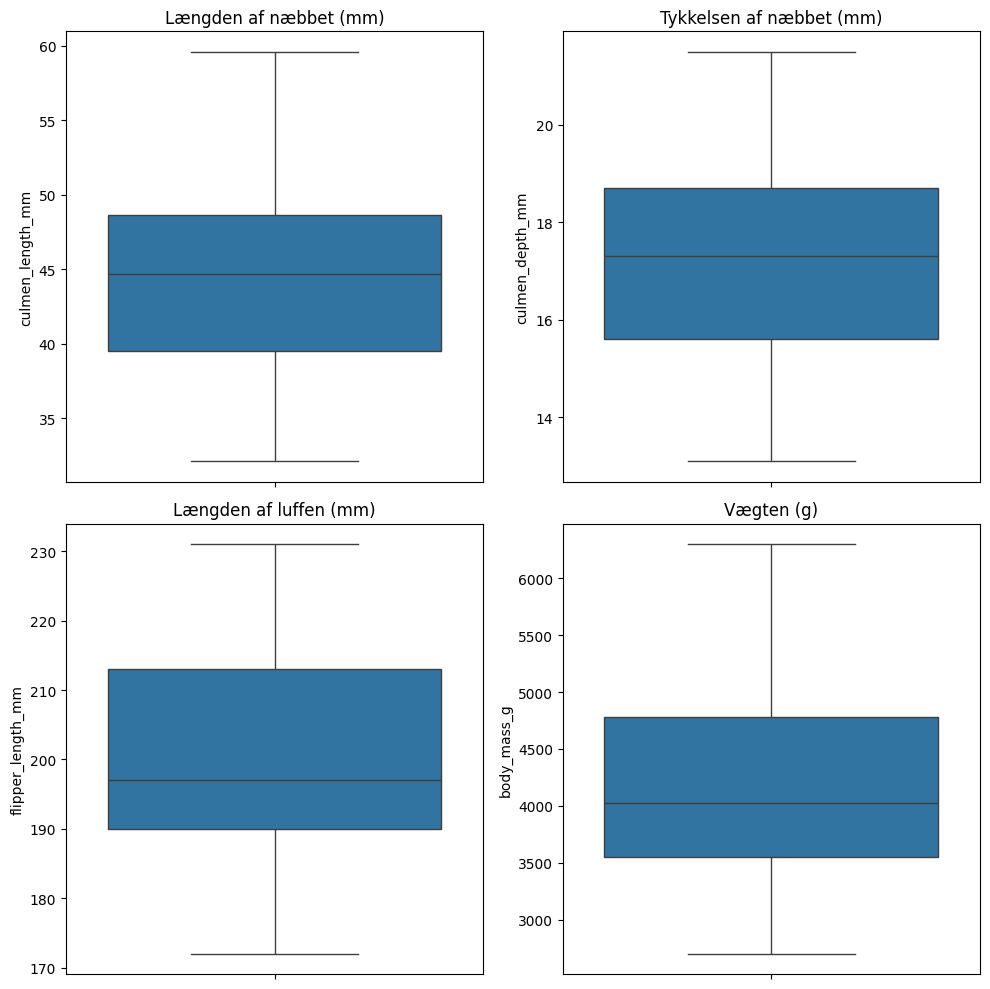

In [99]:
def boxplot_cats(df, fig_size):
    fig, axs = plt.subplots(2,2,figsize=fig_size)
    axs[0,0].set_title("Længden af næbbet (mm)")
    axs[0,1].set_title("Tykkelsen af næbbet (mm)")
    axs[1,0].set_title("Længden af luffen (mm)")
    axs[1,1].set_title("Vægten (g)")
    sns.boxplot(df['culmen_length_mm'], ax=axs[0,0])
    sns.boxplot(df['culmen_depth_mm'], ax=axs[0,1])
    sns.boxplot(df['flipper_length_mm'], ax=axs[1,0])
    sns.boxplot(df['body_mass_g'], ax=axs[1,1])
    plt.tight_layout()
    plt.show()

boxplot_cats(df,(10,10))

_Vi bemærker ikke noget særligt ved boksplottene._

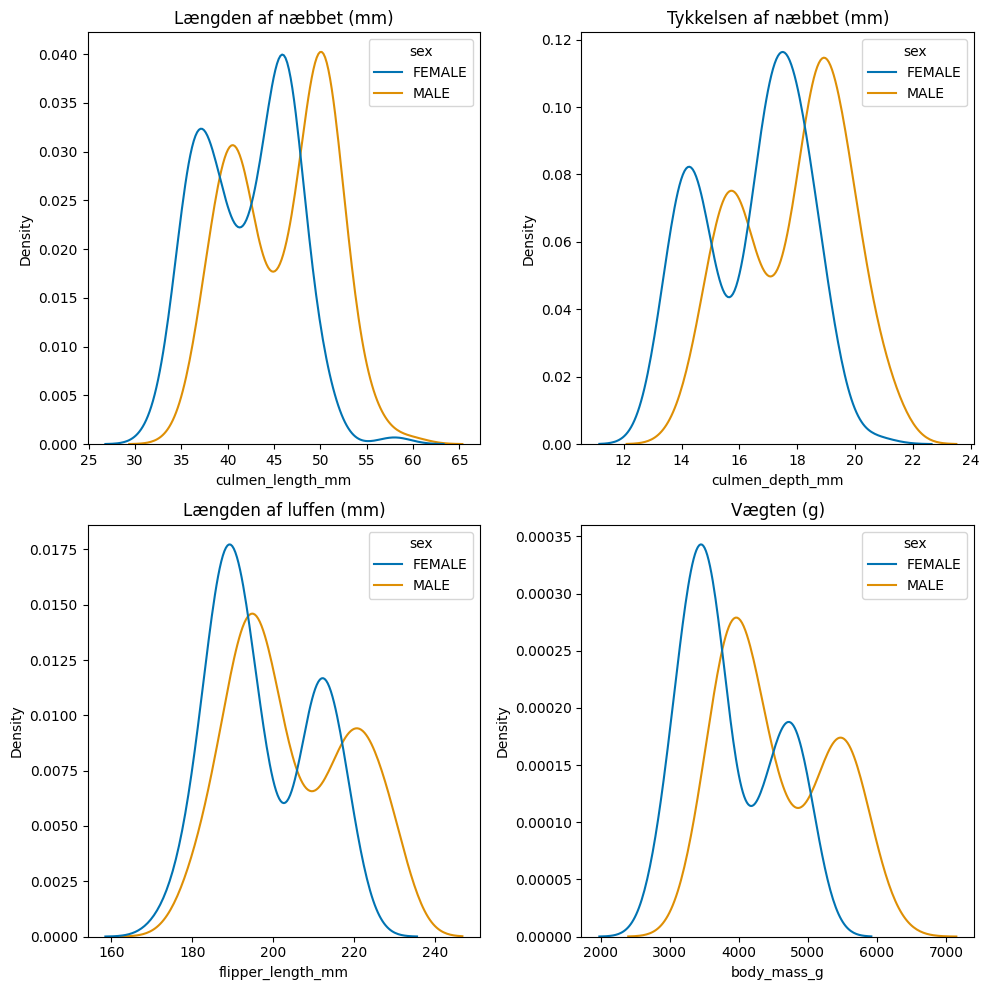

In [100]:
def kdeplot_cats(df, fig_size):
    fig, axs = plt.subplots(2,2,figsize=fig_size)
    axs[0,0].set_title("Længden af næbbet (mm)")
    axs[0,1].set_title("Tykkelsen af næbbet (mm)")
    axs[1,0].set_title("Længden af luffen (mm)")
    axs[1,1].set_title("Vægten (g)")
    sns.kdeplot(data=df, x='culmen_length_mm', ax=axs[0,0], hue='sex', hue_order=['FEMALE', 'MALE'], palette='colorblind')
    sns.kdeplot(data=df, x='culmen_depth_mm', ax=axs[0,1], hue='sex', hue_order=['FEMALE', 'MALE'], palette='colorblind')
    sns.kdeplot(data=df, x='flipper_length_mm', ax=axs[1,0], hue='sex', hue_order=['FEMALE', 'MALE'], palette='colorblind')
    sns.kdeplot(data=df, x='body_mass_g', ax=axs[1,1], hue='sex', hue_order=['FEMALE', 'MALE'], palette='colorblind')
    plt.tight_layout()
    plt.show()

kdeplot_cats(df, (10,10))

_Tæthedsfunktionerne for fordelingerne viser ikke noget, der tyder på fejlværdier. Generelt set er hanpingiviner større end hunpingviner, hvilket ikke er overraskende._

3. Skalering af data som forberedelse til K-means clustering

_I forhold til både udregning af varians og euklidisk afstand betyder størrelsen af de indgående værdier meget._

_For or den euklidiske afstand gælder_ $t\rightarrow \text{d}(\vec{u},t\cdot\vec{v})^2=\text{O}(t^2)$.

_Derfor kommer features med numerisk store værdier til at vægte tungere i forhold til features med mindre værdier. Når vi ikke på forhånd ved, hvilke features, der er de vigtigste, ønsker vi ikke forskellig vægt af dem i udgangspunktet._

_Vi vælger at standardisere i stedet for at normalisere._

_Det er et krav, at alle features er numeriske, så vi konverterer 'MALE' til -1 og 'FEMALE' til 1 i 'sex'-featuren._

In [101]:

scaled_df = df.copy()
scaled_df['sex'] = df['sex'].map({'MALE': -1, 'FEMALE': 1})
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df))

In [102]:
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,332.0,-4.708416e-16,1.001509,-2.189667,-0.830434,0.124703,0.845648,2.861539
1,332.0,1.284113e-16,1.001509,-2.070694,-0.793438,0.075096,0.790360,2.220887
2,332.0,7.276642e-16,1.001509,-2.067519,-0.783164,-0.283693,0.857956,2.142311
3,332.0,4.280378e-17,1.001509,-1.871059,-0.815350,-0.225395,0.713876,2.600180
4,332.0,1.391123e-16,1.001509,-0.993994,-0.993994,-0.993994,1.006042,1.006042


In [103]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       332 non-null    float64
 1   1       332 non-null    float64
 2   2       332 non-null    float64
 3   3       332 non-null    float64
 4   4       332 non-null    float64
dtypes: float64(5)
memory usage: 13.1 KB


_Som forventet har alle skalerede features middelværdi 0 og spredning 1._

4. "Albuemetoden"

_Vi anvender den såkaldte albuemetode til at finde den "bedste" værdi af k._

_Vi tager en række k-værdier og kører K-means-algoritmen på data, og beregner den samlede kvadratafstand fra klyngecentrene til punkterne i klyngerne. Disse værdier plottes på y-aksen sammen med k'erne på x-aksen._

_Vi ved, at den samlede kvadratafstand går mod 0, når k går mod antallet af datapunkter, så vi finder ikke det k, hvor kvadratafstanden er mindst, men leder derimod efter en så lille k-værdi som muligt, hvor marginalforbedringen af kvadratafstanden er lille._

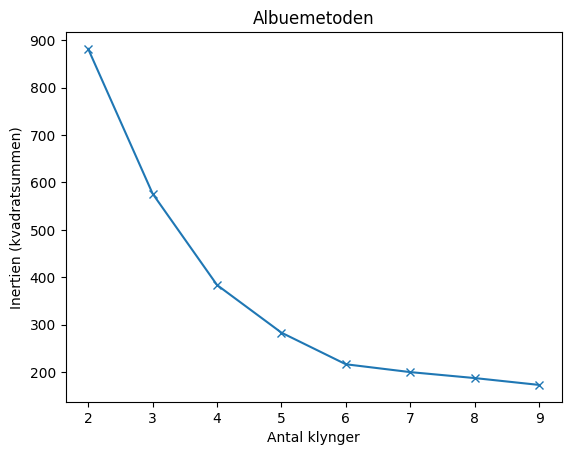

In [104]:

mulige_k = np.arange(2,10,1) # Vi gætter på, at 9 er højt nok (ellers laver vi det om...)
inertias = [] # Kvadratsummen af afstandene fra punkterne til nærmeste klyngecenter

for i in mulige_k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)

plt.title('Albuemetoden')
plt.xlabel('Antal klynger')
plt.ylabel('Inertien (kvadratsummen)')
plt.plot(mulige_k, inertias, marker='x');

_Det er ikke helt klart, hvor albuen er, men i hvert fald kan vi udlukke, at det giver mening at tage mere en 5 klynger med._

_Som alternativ hjælp til albuemetoden, findes der en silhuetmetode, som vi supplerer med._

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

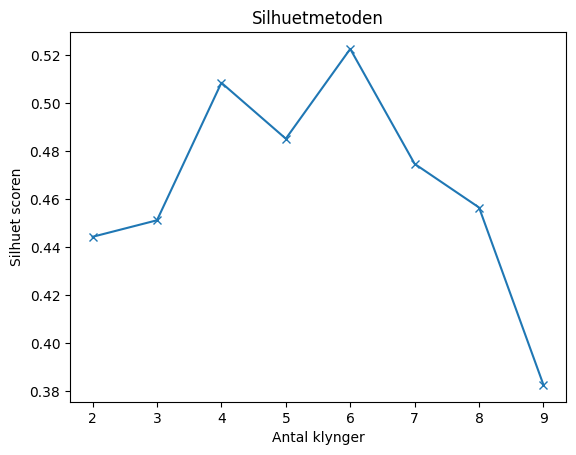

In [105]:
silhuette_scores = []

for n_clusters in mulige_k:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaled_df)

    silhuette_scores.append(silhouette_score(scaled_df, cluster_labels))
    
plt.title('Silhuetmetoden')
plt.xlabel('Antal klynger')
plt.ylabel('Silhuet scoren')
plt.plot(mulige_k, silhuette_scores, marker='x');

_Her gælder det om at have en høj score. Samlet set kunne det se ud som om, at k=4 ville være et godt bud._

5. K-means clustering

_Vi forsøger først med k = 4 på grund af ovenstående forundersøgelser._

In [106]:
scaled_df[scaled_df.columns[0:5]].describe().T

,count,mean,std,min,25%,50%,75%,max
0,332.0,-4.708416e-16,1.001509,-2.189667,-0.830434,0.124703,0.845648,2.861539
1,332.0,1.284113e-16,1.001509,-2.070694,-0.793438,0.075096,0.790360,2.220887
2,332.0,7.276642e-16,1.001509,-2.067519,-0.783164,-0.283693,0.857956,2.142311
3,332.0,4.280378e-17,1.001509,-1.871059,-0.815350,-0.225395,0.713876,2.600180
4,332.0,1.391123e-16,1.001509,-0.993994,-0.993994,-0.993994,1.006042,1.006042


In [107]:
kmeans4 = KMeans(n_clusters=4)
kmeans4.fit(scaled_df[scaled_df.columns[0:5]])

KMeans(n_clusters=4)

In [108]:
scaled_df['Label_4'] = kmeans4.labels_

_For at få et visulet overblik over klyngerne, plotter vi de forskellige feature op mod hinanden parvist._

_Vi håber på at kunne se tydelige klynger._

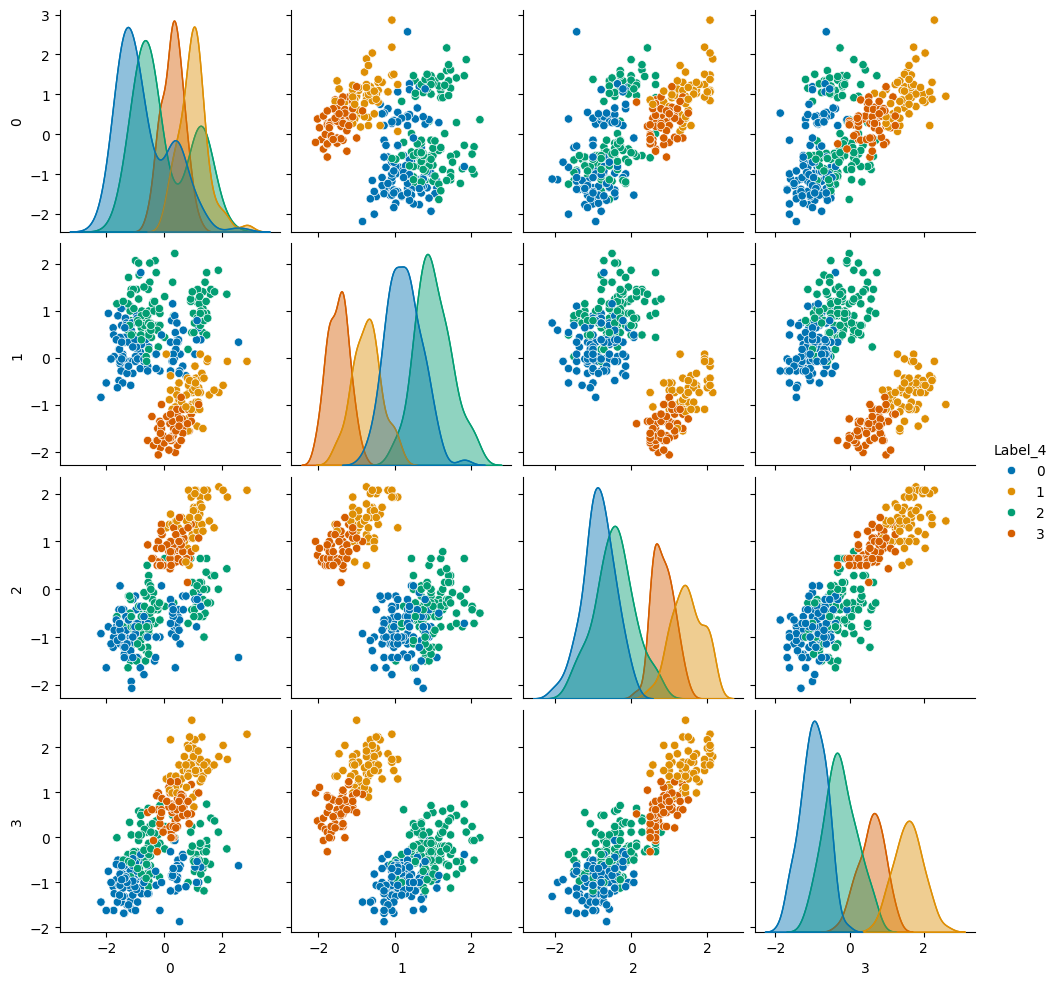

In [109]:
def make_pairplot(data, label, clusters):
    pp = sns.pairplot(data[data.columns[0:4].union([label])], hue=label, hue_order=range(clusters), palette='colorblind')
    pp.map_diag(sns.kdeplot, fill=True)
    pp.map_offdiag(sns.scatterplot)

make_pairplot(scaled_df, 'Label_4', 4)

_Analyse af figuren:_

_Featureparrene (1,2) og (1,3) ser ud til tydeligt at opdele datapunkterne i to klynger. Det er til gengæld ikke tydeligt, at der skulle være fire klynger._

_Vores konklusion indtil videre må være, at der i hvert fald kan laves 2 klynger, men at der nok ikke kan laves 4 klynger._

_Vi prøver derfor at gå helt tilbage til to klynger for at få et billede af den opdeling._

In [110]:
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(scaled_df[scaled_df.columns[0:5]])

KMeans(n_clusters=2)

In [111]:
scaled_df['Label_2'] = kmeans2.labels_

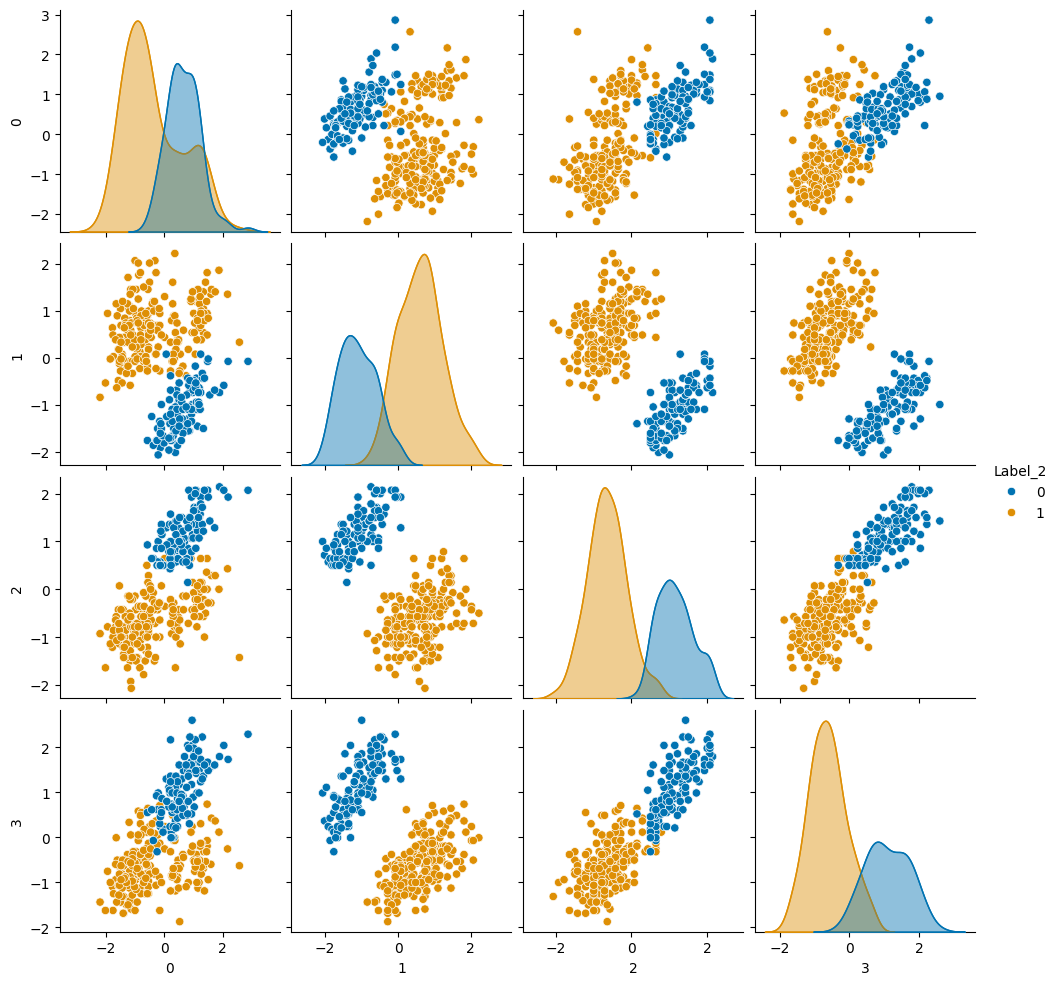

In [112]:
make_pairplot(scaled_df, 'Label_2', 2)

_Analyse af figuren:_

_Der er helt tydeligt belæg for, at datapunkterne kan opdeles i to grupper._

_Featureparrene (0,2) og (0,3) giver anledning til en overvejelse om, at den blå gruppe måske kan opdeles yderligere i to._

_Det undersøger vi i det følgende afsnit._

Først erstatter vi igen ikke numeriske data med numerisk data. Tidligere blev det gjort i df_copied. Men vi gør det her i df.


In [113]:

df['sex'] = df['sex'].replace({'MALE': -1, 'FEMALE': 1})

/var/folders/8w/46nk4t7j4qj6pnt_jtgdzts40000gq/T/ipykernel_7851/3957482712.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'MALE': -1, 'FEMALE': 1})


 For at beregne fornuftige centre, vil det give et skævt billede hvis der er forskellige enheder på de forskellige features. Derfor vil vi skalere data.

In [114]:
scaler = StandardScaler()
penguins_scaled = scaler.fit_transform(df) 

Vi vil plotte de kolonner der svarer til culmen_length og culmen depth. Det er kolonnerne på plads 0 og 1 i penguins_scaled. Vi vil dele dem i 3 klustre.
Desuden sætter vi labels på.

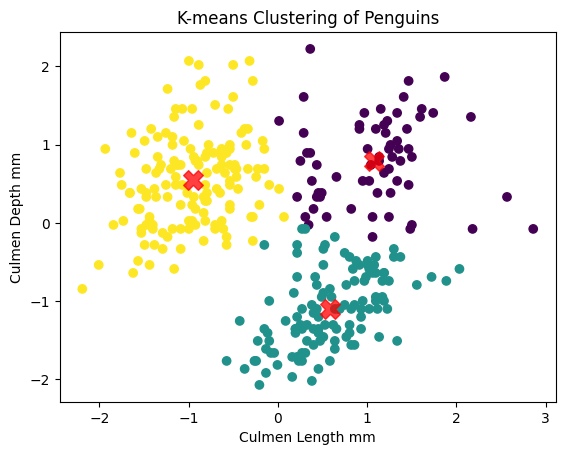

In [115]:
X = penguins_scaled[:, [0, 1]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
labels1 = kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels1, cmap='viridis')  # Plot datapunkter farvelagt efter kluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Plot klustercentrene
plt.xlabel('Culmen Length mm')
plt.ylabel('Culmen Depth mm')
plt.title('K-means Clustering of Penguins')
plt.show()

Vi vil plotte de kolonner der svarer til culmen_length og flipper length. Det er kolonnerne på plads 0 og 2 i penguins_scaled. Vi deler igen i 3 klustre

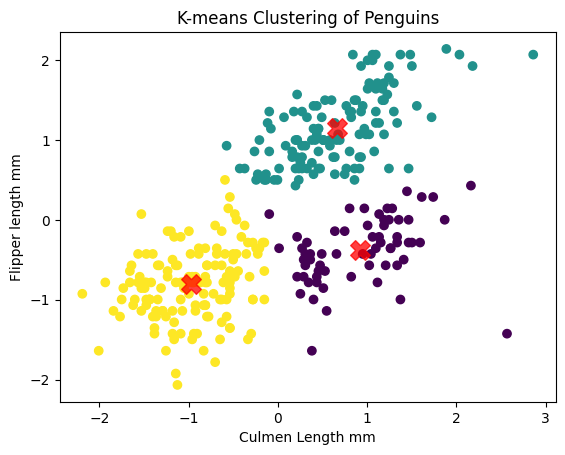

In [116]:
X = penguins_scaled[:, [0, 2]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
labels2 = kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels2, cmap='viridis')  # Plot datapunkter farvelagt efter kluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Plot klustercentrene

plt.xlabel('Culmen Length mm')
plt.ylabel('Flipper length mm')
plt.title('K-means Clustering of Penguins')

plt.show()

Tilsidst vil vi plotte de kolonner der svarer til culmen_length og body_mass. Det er kolonnerne på plads 0 og 3 i penguins_scaled. Vi deler igen i 3 klustre

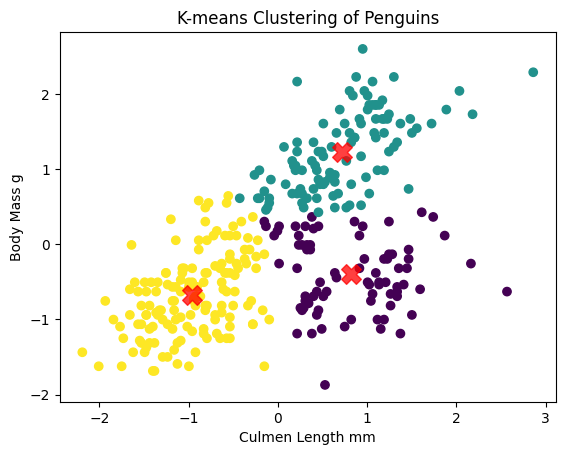

In [117]:
X = penguins_scaled[:, [0, 3]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
labels3 = kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels3, cmap='viridis')  # Plot datapunkter farvelagt efter kluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Plot klustercentrene
plt.xlabel('Culmen Length mm')
plt.ylabel('Body Mass g')
plt.title('K-means Clustering of Penguins')

plt.show()

Vi har en tydelig opdeling af de tre klustre i hvert plot. 

Vi undersøger nu om pingvinerne har samme labels i de forkellige klustreplot. Altså om en pingvin der er gul i det ene plot også er gul i de andre plots.

In [118]:
df.reset_index(drop=True, inplace=True)
df['klynge_label1'] = labels1
df['klynge_label2'] = labels2
df['klynge_label3'] = labels3

antal_forskellige_labels = df[(df['klynge_label1'] != df['klynge_label2']) | 
                                (df['klynge_label1'] != df['klynge_label3']) | 
                                (df['klynge_label2'] != df['klynge_label3'])].shape[0]

print(f"Antall rækker hvor labels1, labels2 og labels3 er forskellige: {antal_forskellige_labels}")


Antall rækker hvor labels1, labels2 og labels3 er forskellige: 42


Da der kun er 42 ud af 343, vil vi fjerne disse 42.

In [119]:
# Behold rækker hvor alle klynge_labels er ens. 
df_filtret = df[~((df['klynge_label1'] != df['klynge_label2']) | 
                 (df['klynge_label1'] != df['klynge_label3']) | 
                 (df['klynge_label2'] != df['klynge_label3']))]



Så gentager vi de tre klustreplot på det filtrerede dataset

In [120]:
penguins_filtret_scaled = scaler.fit_transform(df_filtret) 

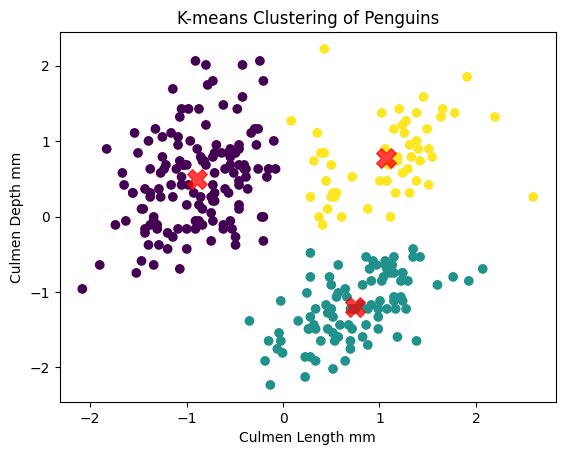

In [121]:
X = penguins_filtret_scaled[:, [0, 1]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
labels1 = kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels1, cmap='viridis')  # Plot datapunkter farvelagt efter kluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Plot klustercentrene
plt.xlabel('Culmen Length mm')
plt.ylabel('Culmen Depth mm')
plt.title('K-means Clustering of Penguins')
plt.show()

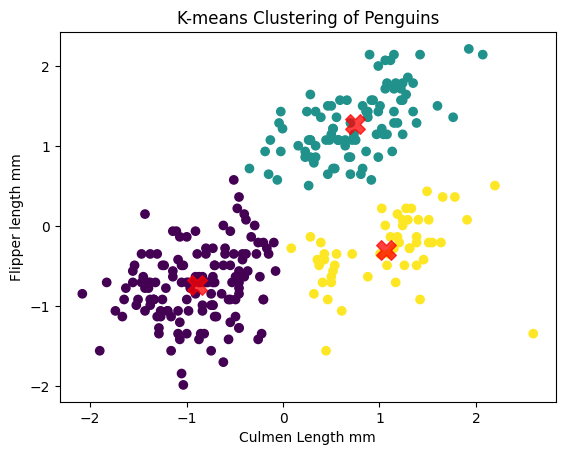

In [122]:
X = penguins_filtret_scaled[:, [0, 2]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
labels2 = kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels2, cmap='viridis')  # Plot datapunkter farvelagt efter kluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Plot klustercentrene

plt.xlabel('Culmen Length mm')
plt.ylabel('Flipper length mm')
plt.title('K-means Clustering of Penguins')

plt.show()

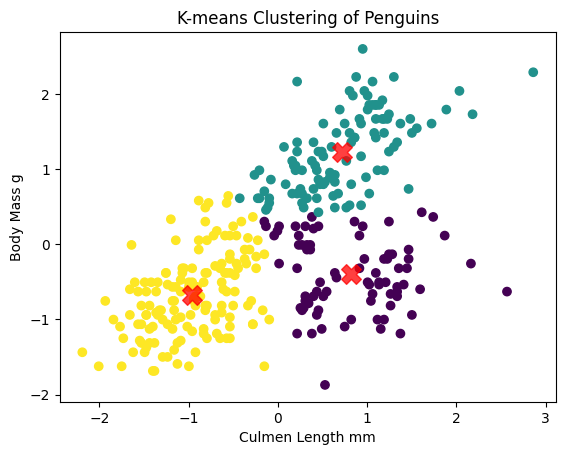

In [123]:
X = penguins_scaled[:, [0, 3]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
labels3 = kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels3, cmap='viridis')  # Plot datapunkter farvelagt efter kluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Plot klustercentrene
plt.xlabel('Culmen Length mm')
plt.ylabel('Body Mass g')
plt.title('K-means Clustering of Penguins')

plt.show()

Vi har nu en endnu mere tydelig opdeling i 3 klustre, hvor vi kan se at 
- pingviner med med kort næb har høj næbdybe, korte flipper og lav vægt. (den gule gruppe)
- pingviner med med langt næb deler sig i to grupper:
- - Den ene gruppe (den grønne) har lav næbdybde, høj flipperlængde og høj vægt.
- - Den anden gruppe (den lilla) har lav næbdybde, lav flipper længde og lav vægt.

Vi vil undersøge variationen i de enkelte klustre ved at lave boxplot.

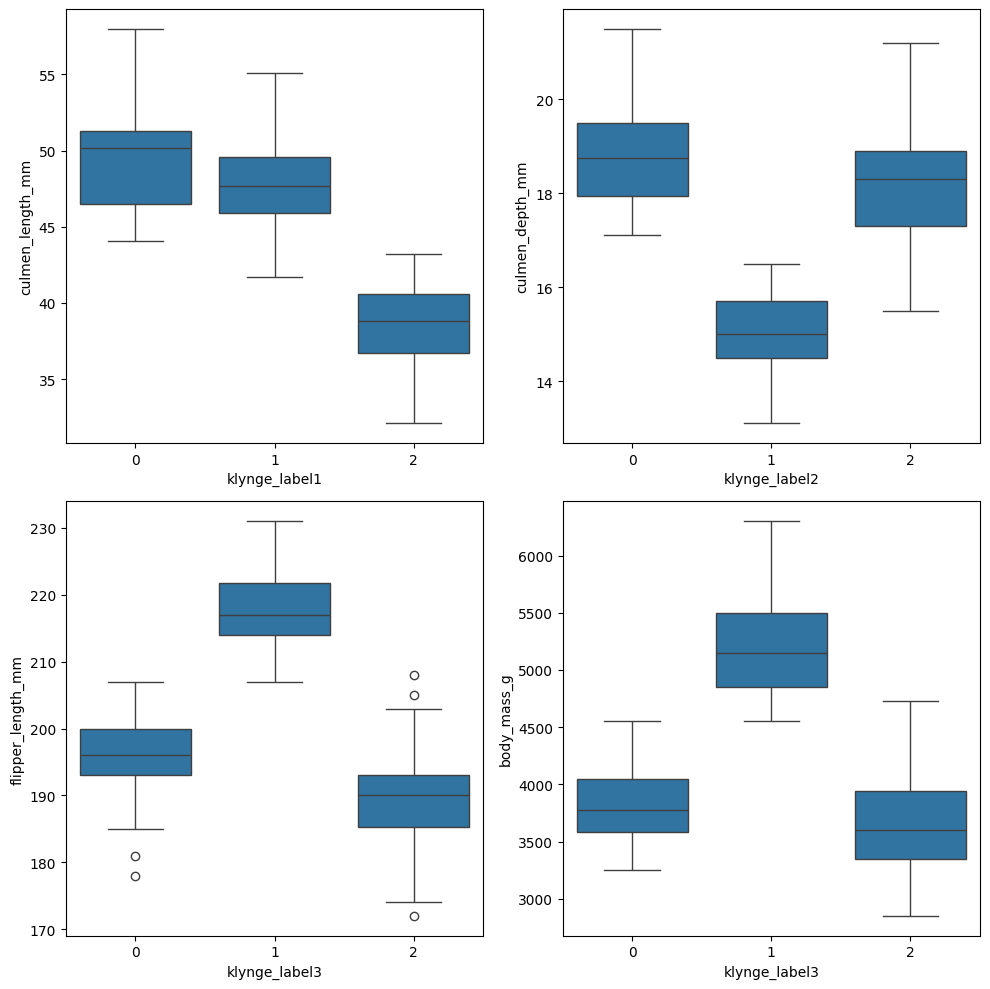

In [124]:
#boxplot over de 3 klynge_labels
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.boxplot(x='klynge_label1', y='culmen_length_mm', data=df_filtret, ax=axs[0, 0])
sns.boxplot(x='klynge_label2', y='culmen_depth_mm', data=df_filtret, ax=axs[0, 1])
sns.boxplot(x='klynge_label3', y='flipper_length_mm', data=df_filtret, ax=axs[1, 0])
sns.boxplot(x='klynge_label3', y='body_mass_g', data=df_filtret, ax=axs[1, 1])
plt.tight_layout()


In [125]:
# Beregn min og max for hver variabel og klynge_label
min_max_culmen_length = df_filtret.groupby('klynge_label1')['culmen_length_mm'].agg(['min', 'max'])
min_max_culmen_depth = df_filtret.groupby('klynge_label2')['culmen_depth_mm'].agg(['min', 'max'])
min_max_flipper_length = df_filtret.groupby('klynge_label3')['flipper_length_mm'].agg(['min', 'max'])
min_max_body_mass = df_filtret.groupby('klynge_label3')['body_mass_g'].agg(['min', 'max'])

# Vis resultatene
print("Culmen Length mm (min, max) per klynge_label1:\n", min_max_culmen_length)
print("\nCulmen Depth mm (min, max) per klynge_label2:\n", min_max_culmen_depth)
print("\nFlipper Length mm (min, max) per klynge_label3:\n", min_max_flipper_length)
print("\nBody Mass g (min, max) per klynge_label3:\n", min_max_body_mass)

Culmen Length mm (min, max) per klynge_label1:
                 min   max
klynge_label1            
0              44.1  58.0
1              41.7  55.1
2              32.1  43.2

Culmen Depth mm (min, max) per klynge_label2:
                 min   max
klynge_label2            
0              17.1  21.5
1              13.1  16.5
2              15.5  21.2

Flipper Length mm (min, max) per klynge_label3:
                  min    max
klynge_label3              
0              178.0  207.0
1              207.0  231.0
2              172.0  208.0

Body Mass g (min, max) per klynge_label3:
                   min     max
klynge_label3                
0              3250.0  4550.0
1              4550.0  6300.0
2              2850.0  4725.0


Bemærk at navnene klynge_label1 - 3 er noget indbygget i koden og har ikke noget at gøre med de labels 0,1,2 som er lilla, grøn og gul i ovenstående plots.

Ud fra disse boxplots kan vi se at 
- Den gule gruppe (label2) består af pingviner med med **kort næb** (32.1mm-43.2mm), **høj næbdybe** (15.5mm - 21.2mm), **korte flipper**(172mm-208mm) og **lav vægt**(2850g-4725g). 

Pingviner med med langt næb deler sig i to grupper
- Den grønne(label1) har **langt næb**(41.7mm-55.1mm), **lav næbdybde**(13.1mm-16.5mm), **høj flipperlængde**(207.0mm-231.0mm) og **høj vægt**(4550.0g-6300.0g)
- Den lilla(label0) har **langt næb**(44.1mm-58.0mm), **lav næbdybde**(17.1mm-21.5mm), **lav flipperlængde**(178.0mm-207.0mm) og  **lav vægt**(3250g-4550g)

Vi har altså 3 tydelige grupper, som vi nu har sat nogle tal på.